# Balanced Tree

### Libraries

In [11]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

import scipy
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import classic, random_graphs

## node colour
color_map = ["steelblue"]

### Supporting Functions

In [5]:
## supporting functions
from preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from metrics import compute_mig, compute_mi
from generating import generate_single, generate_manifold 
from latent_space import vis2D, visDistr

## Loading and Preprocessing Network Data

### Loading Network Data

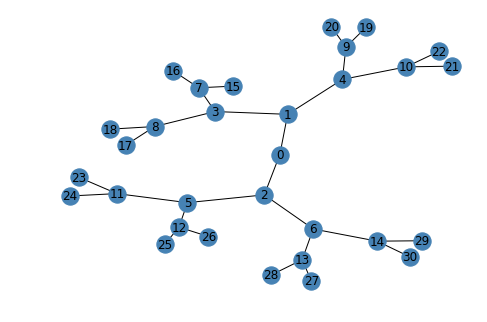

In [6]:
def get_graph(b,h,draw): 

    g = classic.balanced_tree(b, h)

    if draw:
        nx.draw(g, node_color = color_map, with_labels = True)
        plt.show()
    
    return g

g = get_graph(b = 2, h = 4, draw = True)

# Generating Training Data

In [7]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            h = dataArgs["h"]         # generate fixed number of nodes n_max
        else:
            h = random.randint(0, dataArgs["h"]) # generate number of nodes n between 1 and n_max and

        b = random.randint(dataArgs["b"][0], dataArgs["b"][1]) 
        
        g = get_graph(b, h, draw = False)

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])


        ## Generate Ground Truth features____________________________________

        if nx.is_connected(g):
            diameter = nx.diameter(g)
        else:
            diameter = -1

        density = nx.density(g)

        ## toDO: add more graph topologies and figure out good data structure - dicts?


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["b"] = b
        t["h"] = h
        t["diameter"] = diameter
        t["density"] = density

        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    return G,T,input_shape,output_shape
    
# n formula = b*(b**h) - 1
dataArgs = {"n_graphs": 100, "n_max": 324, "h": 4, "b": [1,2], "fix_n": False, "diag_offset": -1, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, input_shape, output_shape = generate_data(dataArgs)


input_shape: (324, 324, 1) , output_shape: (324, 324, 1)


# beta-VAE (MLP, Conv)

## Build Model

In [8]:
# network parameters
modelArgs = {"nn_architecture": "conv", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



## MODEL ______________________________________________________________

## Multi-layer Perceptron without convolutions__________________________________

if modelArgs["nn_architecture"] == "mlp":

    ## 1) build encoder model
    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

    ## 2) build decoder model
    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    y = Dense(64, activation='relu')(latent_inputs)
    y = Dense(128, activation='relu')(y)
    outputs = Dense(modelArgs["output_shape"], activation='sigmoid')(y)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


    ## INSTANTIATE ________________________________________________

    ## 1) instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_graph')
    #vae.summary()





## Convolutional Neural Network_________________________________

if modelArgs["nn_architecture"] == "conv":


    ## 1) build encoder model____________________________________

    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = inputs

    for i in range(2):
        modelArgs['filters'] *= 2
        x = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)



    ## 2) build decoder model____________________________________

    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for i in range(2):
        x = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)
        modelArgs['filters'] //= 2

    outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid', padding='same', name='decoder_output')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["output_shape"],), name='z')([z_mean, z_log_var])



    ## INSTANTIATE___________________________________

    ## 1) instantiate encoder model    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='conv_vae')
    #vae.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 324, 324, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 162, 162, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 81, 81, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 419904)       0           conv2d_2[0][0]                   
_____________________________________

## Train Model

In [9]:
## Configs  
trainArgs = {"loss": "mse", "weights": "train", "early_stop": 5, "batch_size": 128, "epochs": 10, "beta": 10, "data_split": 0.2}

## MLP: beta =
## CNN: beta = (latent 2 / beta 25)

## Train and Validation Split _______________________________________________

x_train, x_test, y_train, y_test = train_test_split(G, T, test_size= trainArgs["data_split"], random_state=1, shuffle=True)

models = (encoder, decoder)
data = (x_test, y_test)


## VAE loss = mse_loss or xent_loss + kl_loss_______________________

if trainArgs["loss"] == "mse":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "conv":
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]
        
if trainArgs["loss"] == "binary_crossentropy":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "conv":
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]



## LOSS _____________________________________________

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)



## TRAIN______________________________________________

# load the autoencoder weights

if trainArgs["weights"] == "load":
    
    vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

# train the autoencoder

elif trainArgs["weights"] == "train":
    
    # Set callback functions to early stop training and save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5", save_best_only=True)]
    
    vae.fit(x_train, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], callbacks=callbacks, validation_data=(x_test, None))
    vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 324, 324, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 6737364   
_________________________________________________________________
decoder (Model)              (None, 324, 324, 1)       1315393   
Total params: 8,052,757
Trainable params: 8,052,757
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 12s 146ms/step - loss: 26235.6719 - val_loss: 26044.3359
Epoch 2/10
80/80 [==============================] - 9s 113ms/step - loss: 26045.2129 - val_loss: 25797.9648
Epoch 3/10
80/80 [==============================] - 10s 120ms/step - loss: 25803.4414 -

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

Mutual Information Gap: 0.5086823756131795


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:328: RuntimeWarning: invalid value encountered in double_scalars


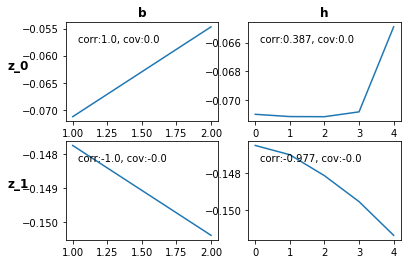

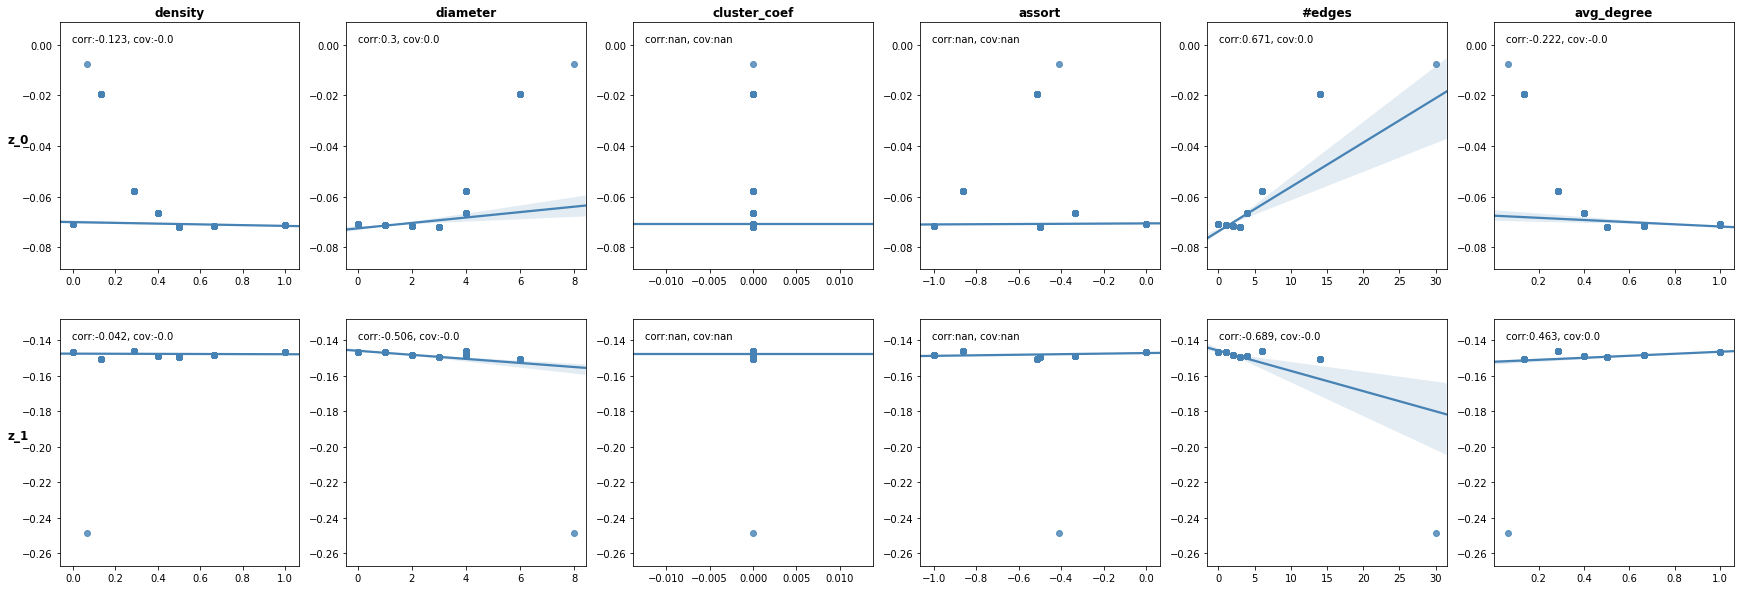

In [12]:
def latent_space_feature_correlation(analyzeArgs, modelArgs, dataArgs, models,batch_size=128,model_name="vae_graph"):

    encoder, decoder = models  # trained models
    
    
    
    if analyzeArgs["root_params"] == 1 or modelArgs["latent_dim"] == 1:
        
        ## Generate Graph Data_______________________________
        
        b = dataArgs["b"][1]
        H = np.linspace(0,dataArgs["h"], analyzeArgs["n_config_graphs"], dtype = int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_topol_params = ["h","density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]
        
        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth_Topol = np.zeros((analyzeArgs["n_config_graphs"], len(growth_topol_params)))
    
        for i, h in enumerate(H):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(b), int(h), draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth_Topol[i,0] = h
            Growth_Topol[i,1] = density
            Growth_Topol[i,2] = diameter
            Growth_Topol[i,3] = cluster_coef
            Growth_Topol[i,4] = assort
            Growth_Topol[i,5] = edges
            Growth_Topol[i,6] = avg_degree

  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
        
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            mig = compute_mig(H, np.squeeze(z_mean))
            
        
        ## Visualize Latent Variables x Graph Properties ____________________________
        fig, ax = plt.subplots(nrows= z_mean.shape[1], ncols= Growth_Topol.shape[1], figsize=(20, 10))

        for latent_z, row in enumerate(ax):  
            
            if z_mean.shape[1] == 1:   # only one latent variable
                
                if latent_z == 0:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    row.plot(x, y) 

                else:
                    y = z_mean[:,0]
                    x = Growth_Topol[:,latent_z]
                    #row.scatter(x, y) 
                    sns.regplot(x, y, color="steelblue", ax=row)

                    ## plot trend line
                    #x = np.nan_to_num(x)
                    #y = np.nan_to_num(y)

                    #z = np.polyfit(x, y, 1)
                    #p = np.poly1d(z)
                    #row.plot(x,p(x),"steelblue")
                    
                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

                    
            else:                     # multiple latent variables
                
                for feature, col in enumerate(row):

                    if feature == 0:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        col.plot(x, y) 

                    else:
                        y = z_mean[:,latent_z]
                        x = Growth_Topol[:,feature]
                        #col.scatter(x, y) 
                        sns.regplot(x, y, color="steelblue", ax=col)

                        ## plot trend line
                        #x = np.nan_to_num(x)
                        #y = np.nan_to_num(y)

                        #z = np.polyfit(x, y, 1)
                        #p = np.poly1d(z)
                        #col.plot(x,p(x),"steelblue")
            
                
                    ## compute correlation and standardized covariance
                    corr = round(pearsonr(x,y)[0],3)
                    cov = round(np.cov(x, y)[0][1]/max(x),3)
                    col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________
        
        if z_mean.shape[1] == 1:   # only one latent variable
                
            cols = [t for t in growth_topol_params]
            
            for axis, col in zip(ax[:,], cols):
                axis.set_title(col, fontweight='bold')
                
        
        if z_mean.shape[1] != 1:   # more than one latent variable
            
            rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
            cols = [t for t in growth_topol_params]

            for axis, row in zip(ax[:,0], rows):
                axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')
            
            for axis, col in zip(ax[0], cols):
                axis.set_title(col, fontweight='bold')

        plt.show()


        

    if analyzeArgs["root_params"] == 2 and modelArgs["latent_dim"] != 1:
        
        ## Generate Graph Data_______________________________
        B = np.linspace(dataArgs["b"][0],dataArgs["b"][1], analyzeArgs["n_config_graphs"], dtype = int)
        H = np.linspace(0,dataArgs["h"], analyzeArgs["n_config_graphs"], dtype = int)  # array 0.1, 0.2 - 1 / n_config_graphs  
        
        ## growth and topol parameters
        growth_params = ["b", "h"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(B,H)))
        

        for i, (b,h) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________

            g = get_graph(int(b), int(h), draw = False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = reshape_A(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = int(b)
            Growth[i,1] = int(h)

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        
                
        ## Measure the Mutual Information Gap ____________________________________________
        if analyzeArgs["metric"] == "mig":
            #mi = compute_mi(P, np.squeeze(z_mean))
            mig = compute_mig(Growth, z_mean)
        
        
        ##  Reshape Array according to Parameters  
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))
            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                if feature == 0:
                    feature_1 = 1
                if feature == 1:
                    feature_1 = 0

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature_1)
                x = np.mean(Growth[:,:,feature], axis= feature_1)
                col.plot(x, y)  

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Graph Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                sns.regplot(x, y, color="steelblue", ax=col)
                #col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

               # try:
               #     ## plot trend line
               #     x = np.nan_to_num(x)
               #     y = np.nan_to_num(y)

               #     z = np.polyfit(x, y, 1)
               #     p = np.poly1d(z)
               #     col.plot(x,p(x),"steelblue")
               # except:
               #     pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


            
            


## PLOT RESULTS ________________________________________

analyzeArgs = {"root_params": 2, "n_config_graphs": 40, "metric": "mig"}
latent_space_feature_correlation(analyzeArgs, modelArgs, dataArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

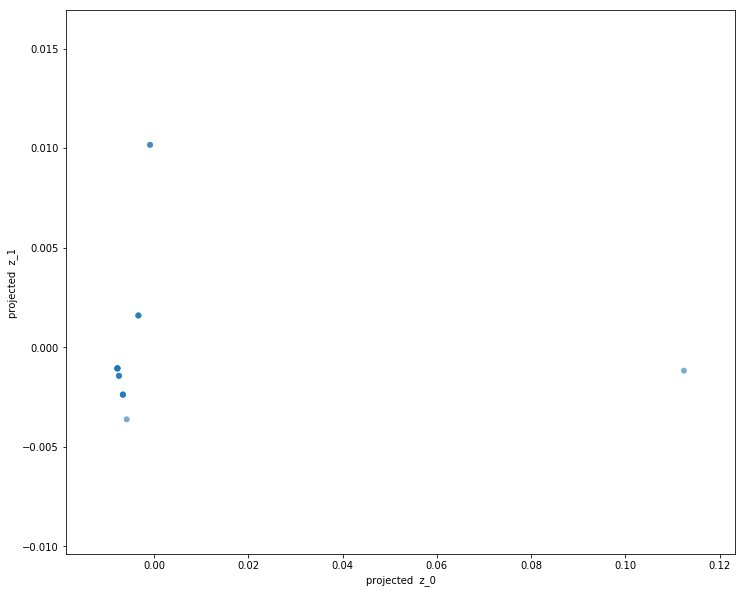

In [13]:
analyzeArgs = {"save_plots": False}
vis2D(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

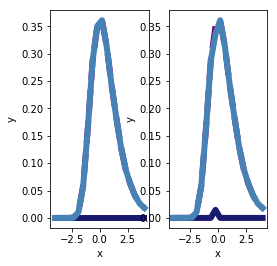

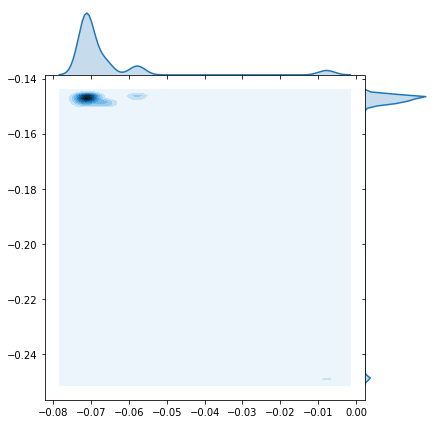

In [14]:
analyzeArgs = {"z": [0,1]}
visDistr(modelArgs, analyzeArgs, models,data,trainArgs["batch_size"])

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


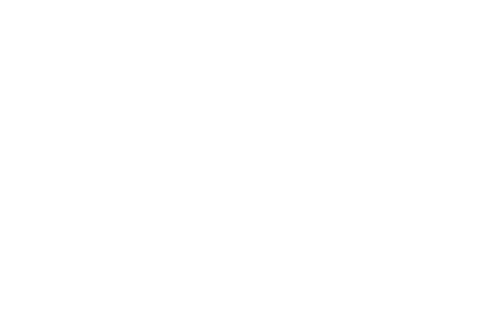

In [15]:
analyzeArgs = {"activations": [0, 0.2], "z": [0,1]}
generate_single(analyzeArgs, modelArgs, dataArgs, models, color_map)

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


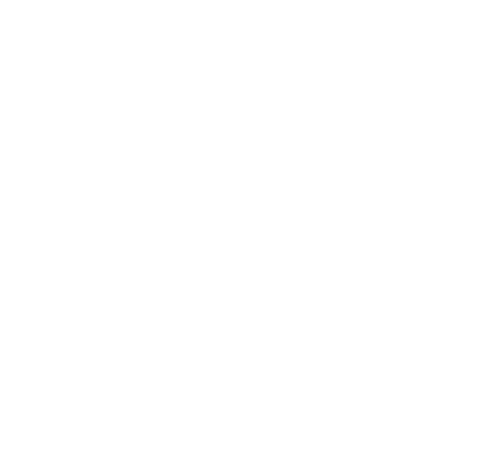

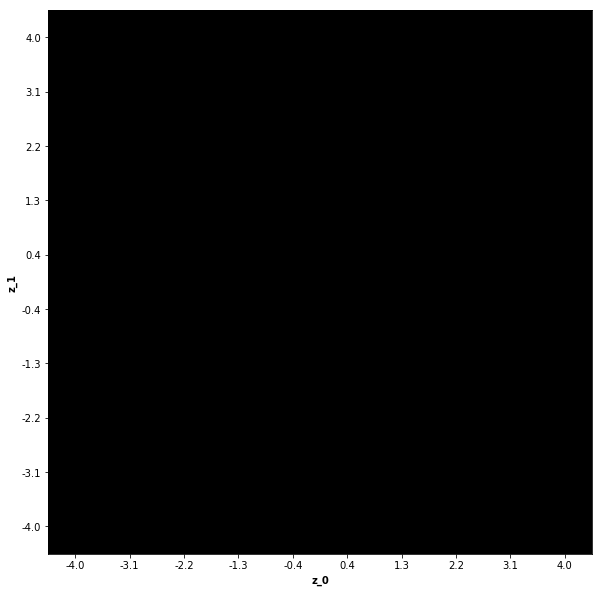

In [16]:
# range, normal, z
analyzeArgs = {"z": [0,1], "sample": "range", "act_range": [-4, 4], "act_scale": 1, "size_of_manifold": 10, "save_plots": False}
generate_manifold(analyzeArgs, modelArgs, dataArgs, models, data, color_map, batch_size=trainArgs["batch_size"])